### "What just happened???"

Here we take an existing modflow model and setup a very complex parameterization system for arrays and boundary conditions.  All parameters are setup as multpliers: the original inputs from the modflow model are saved in separate files and during the forward run, they are multplied by the parameters to form new model inputs.  the forward run script ("forward_run.py") is also written.  And somewhat meaningful prior covariance matrix is constructed from geostatistical structures with out any additional arguements...oh yeah!

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


In [11]:
nam_file = "freyberg.nam"
org_model_ws = "Freyberg_sfr_update"
temp_model_ws = "temp"
new_model_ws = "template"
# load the model, change dir and run once just to make sure everthing is working
m = flopy.modflow.Modflow.load(nam_file,model_ws=org_model_ws,check=False, exe_name="mfnwt",
                              forgive=False,verbose=True)
m.change_model_ws(temp_model_ws,reset_external=True)
m.write_input()
try:
    m.run_model()
except():
    pass


Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> Freyberg_sfr_update/freyberg.nam
Setting filehandles:

--------------------------------------------------
External unit dictionary:
{32: filename:Freyberg_sfr_update/freyberg.nwt, filetype:NWT, 51: filename:Freyberg_sfr_update/freyberg.hds, filetype:DATA(BINARY), 2: filename:Freyberg_sfr_update/freyberg.list, filetype:LIST, 11: filename:Freyberg_sfr_update/freyberg.dis, filetype:DIS, 13: filename:Freyberg_sfr_update/freyberg.bas, filetype:BAS6, 14: filename:Freyberg_sfr_update/freyberg.oc, filetype:OC, 17: filename:Freyberg_sfr_update/freyberg.sfr, filetype:SFR, 50: filename:Freyberg_sfr_update/freyberg.cbc, filetype:DATA(BINARY), 19: filename:Freyberg_sfr_update/freyberg.rch, filetype:RCH, 20: filename:Freyberg_sfr_update/freyberg.wel, filetype:WEL, 60: filename:Freyberg_sfr_update/freyberg.sfr.out, filetype:DATA, 30: filename:Freyberg_sfr_update/freyberg.lmt6, filetype

KeyError: 40

You want some pilot points? We got that...how about one set of recharge multiplier pilot points applied to all stress periods? and sy in layer 1?

## Parameterization

In [3]:
pp_props = [["upw.sy",0], ["rch.rech",None]]

You want some constants (uniform value multipliers)?  We got that too....

In [4]:
const_props = []
for iper in range(m.nper): # recharge for past and future
    const_props.append(["rch.rech",iper])
for k in range(m.nlay):
    const_props.append(["upw.hk",k])
    const_props.append(["upw.ss",k])


You want grid-scale parameter flexibility for hk in all layers? We got that too...and how about sy in layer 1 and vka in layer 2 while we are at it

In [5]:
grid_props = [["upw.sy",0],["upw.vka",1]]
for k in range(m.nlay):
    grid_props.append(["upw.hk",k])
    

Some people like using zones...so we have those too

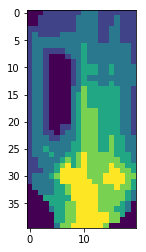

In [6]:
zn_array = np.loadtxt(os.path.join("Freyberg_truth","hk.zones"))
plt.imshow(zn_array)

In [7]:
zone_props = [["upw.ss",0], ["rch.rech",0],["rch.rech",1]]
k_zone_dict = {k:zn_array for k in range(m.nlay)}


But wait, boundary conditions are uncertain too...Can we add some parameter to represent that uncertainty?  You know it!

In [8]:
bc_props = []
for iper in range(m.nper):
    bc_props.append(["wel.flux",iper])

## Observations

Since observations are "free", we can carry lots of them around...

In [9]:
# here were are building a list of stress period, layer pairs (zero-based) that we will use
# to setup obserations from every active model cell for a given pair
hds_kperk = []
for iper in range(m.nper):
    for k in range(m.nlay):
        hds_kperk.append([iper,k])

## Here it goes...
Now we will use all these args to construct a complete PEST interface - template files, instruction files, control file and even the forward run script!  All parameters are setup as multiplers against the existing inputs in the modflow model - the existing inputs are extracted (with flopy) and saved in a sub directory for safe keep and for multiplying against during a forward model run.  The constructor will also write a full (covariates included) prior parameter covariance matrix, which is needed for all sorts of important analyses.|

In [10]:
mfp_boss = pyemu.helpers.PstFromFlopyModel(nam_file,new_model_ws,org_model_ws=temp_model_ws,
                                          pp_props=pp_props,bc_props=bc_props,
                                          zone_props=zone_props,grid_props=grid_props,
                                          const_props=const_props,k_zone_dict=k_zone_dict,
                                          remove_existing=True,pp_space=4,sfr_pars=True,
                                          sfr_obs=True,hds_kperk=hds_kperk)

2018-03-07 08:45:48.134393 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp/freyberg.nam
Setting filehandles:

--------------------------------------------------
External unit dictionary:
{32: filename:temp/freyberg.nwt, filetype:NWT, 19: filename:temp/freyberg.rch, filetype:RCH, 2: filename:temp/freyberg.list, filetype:LIST, 11: filename:temp/freyberg.dis, filetype:DIS, 13: filename:temp/freyberg.bas, filetype:BAS6, 14: filename:temp/freyberg.oc, filetype:OC, 50: filename:temp/freyberg.cbc, filetype:DATA(BINARY), 51: filename:temp/freyberg.hds, filetype:DATA(BINARY), 20: filename:temp/freyberg.wel, filetype:WEL, 60: filename:temp/freyberg.sfr.out, filetype:DATA, 30: filename:temp/freyberg.lmt6, filetype:LMT6, 31: filename:temp/freyberg.upw, filetype:UPW}
--------------------------------------------------

ModflowBas6 free format:True

loading dis package file...
   Loading dis packag

2018-03-07 08:45:48.762024 88 pilot point parameters created
2018-03-07 08:45:48.762383 pilot point 'pargp':sy0,rech0
2018-03-07 08:45:48.762423 finished: calling setup_pilot_point_grid() took: 0:00:00.147072
2018-03-07 08:45:48.764252 starting: calculating factors for k=0
2018-03-07 08:45:48.764484 saving krige variance file:template/pp_k0.var.dat
2018-03-07 08:45:48.764529 saving krige factors file:template/pp_k0.fac
starting interp point loop for 800 points
took 2.212168 seconds
2018-03-07 08:45:51.030320 finished: calculating factors for k=0 took: 0:00:02.266068
2018-03-07 08:45:51.031313 starting: processing pp_prefix:sy0
2018-03-07 08:45:51.042059 starting: processing pp_prefix:rech0
2018-03-07 08:45:51.076298 finished: setting up pilot point process took: 0:00:02.463128
2018-03-07 08:45:51.076620 starting: setting up grid process
2018-03-07 08:45:51.076691 WARNING: grid_geostruct is None, using ExpVario with contribution=1 and a=(max(delc,delr)*10
2018-03-07 08:45:51.076799 fini

/Users/jeremyw/Dev/pyemu/pyemu/utils/gw_utils.py:250: UserWarning: pp_file_to_dataframe has moved to pp_utils
  warnings.warn("pp_file_to_dataframe has moved to pp_utils")


arr_mlt/rech0.dat_pp 0.9999999864000001 1.0 1e-10
arr_mlt/rech0.dat_pp 0.9999999864000001 1.0 1e-10
arr_mlt/rech0.dat_pp 0.9999999864000001 1.0 1e-10
2018-03-07 08:45:51.288514 forward_run line:pyemu.helpers.apply_array_pars()



AssertionError: can't find sfr package...

The ``mpf_boss`` instance containts a ``pyemu.Pst`` object (its already been saved to a file, but you may want to manipulate it more)

In [ ]:
pst = mfp_boss.pst

In [ ]:
pst.npar,pst.nobs

That was crazy easy - this used to take me weeks to get a PEST interface setup with level of complexity

In [ ]:
pst.template_files

In [ ]:
pst.instruction_files

Lets look at that important prior covariance matrix

In [ ]:
cov = pyemu.Cov.from_ascii(os.path.join(new_model_ws,m.name+".pst.prior.cov"))

In [ ]:
cov = cov.x
cov[cov==0] = np.NaN
plt.imshow(cov)

### adjusting parameter bounds
Let's say you don't like the parameter bounds in the new control file (note you can pass a par_bounds arg to the constructor).

In [ ]:
pst.parameter_data

Let's change the ``welflux`` pars

In [ ]:
par = pst.parameter_data #get a ref to the parameter data dataframe
wpars = par.pargp=="welflux"
par.loc[wpars]


In [ ]:
par.loc[wpars,"parubnd"] = 1.1
par.loc[wpars,"parlbnd"] = 0.9
pst.parameter_data

In [ ]:
# now we need to rebuild the prior parameter covariance matrix
mfp_boss.build_prior()

# Boom!